# Nasa NEX with Kerchunk

In [1]:
import pandas as pd 
import xarray as xr 
import s3fs

import glob
import logging
from tempfile import TemporaryDirectory

import dask
import fsspec
import s3fs
import ujson
from distributed import Client
from kerchunk.combine import MultiZarrToZarr
from kerchunk.hdf import SingleHdf5ToZarr



In [2]:
## loading
df = pd.read_csv(
    "s3://carbonplan-climate-impacts/extreme-heat/v1.0/inputs/nex-gddp-cmip6-files.csv"
)
str_split_urls = df[" fileURL"].str.rsplit('/',expand=True) 
edf = pd.DataFrame()
edf['url'] = df[" fileURL"].replace({'https://nex-gddp-cmip6.s3.us-west-2.amazonaws.com/':'s3://nex-gddp-cmip6/'},regex=True)
edf['GCM'] = str_split_urls[4]
edf['scenario'] = str_split_urls[5]
edf['ensemble_member'] = str_split_urls[6]
edf['variable'] = str_split_urls[7]
# str strip to remove all whitespace
edf_obj = edf.select_dtypes(['object'])
edf[edf_obj.columns] = edf_obj.apply(lambda x: x.str.strip())



In [9]:
file_pattern = edf.query("GCM == 'ACCESS-CM2'  & scenario == 'historical' & ensemble_member == 'r1i1p1f1'")['url']
# about 53 GB in netcdf file size!

In [3]:
fs = s3fs.S3FileSystem(anon=True, default_fill_cache=False)
ds = xr.open_dataset(fs.open(edf['url'].iloc[0]),engine='h5netcdf')

738.440270248

In [5]:
client = Client(n_workers=32, silence_logs=logging.ERROR)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/norlandrhagen/proxy/8787/status,
Dashboard: /user/norlandrhagen/proxy/8787/status,Workers: 32
Total threads: 32,Total memory: 248.96 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35639,Workers: 32
Dashboard: /user/norlandrhagen/proxy/8787/status,Total threads: 32
Started: Just now,Total memory: 248.96 GiB
Comm: tcp://127.0.0.1:45209,Total threads: 1
Dashboard: /user/norlandrhagen/proxy/36915/status,Memory: 7.78 GiB
Nanny: tcp://127.0.0.1:37491,


In [10]:
file_pattern

0      s3://nex-gddp-cmip6/NEX-GDDP-CMIP6/ACCESS-CM2/...
1      s3://nex-gddp-cmip6/NEX-GDDP-CMIP6/ACCESS-CM2/...
2      s3://nex-gddp-cmip6/NEX-GDDP-CMIP6/ACCESS-CM2/...
3      s3://nex-gddp-cmip6/NEX-GDDP-CMIP6/ACCESS-CM2/...
4      s3://nex-gddp-cmip6/NEX-GDDP-CMIP6/ACCESS-CM2/...
                             ...                        
580    s3://nex-gddp-cmip6/NEX-GDDP-CMIP6/ACCESS-CM2/...
581    s3://nex-gddp-cmip6/NEX-GDDP-CMIP6/ACCESS-CM2/...
582    s3://nex-gddp-cmip6/NEX-GDDP-CMIP6/ACCESS-CM2/...
583    s3://nex-gddp-cmip6/NEX-GDDP-CMIP6/ACCESS-CM2/...
584    s3://nex-gddp-cmip6/NEX-GDDP-CMIP6/ACCESS-CM2/...
Name: url, Length: 585, dtype: object

In [11]:

fs_read = fsspec.filesystem("s3", anon=True, skip_instance_cache=True)
# This dictionary will be passed as kwargs to `fsspec`. For more details, check out the `foundations/kerchunk_basics` notebook.
so = dict(mode="rb", anon=True, default_fill_cache=False, default_cache_type="first")

# We are creating a temporary directory to store the .json reference files
# Alternately, you could write these to cloud storage.
td = TemporaryDirectory()
temp_dir = td.name
temp_dir

'/tmp/tmph91dhlto'

In [12]:
# Use Kerchunk's `SingleHdf5ToZarr` method to create a `Kerchunk` index from a NetCDF file.
def generate_json_reference(fil, output_dir: str):
    with fs_read.open(fil, **so) as infile:
        h5chunks = SingleHdf5ToZarr(infile, fil, inline_threshold=300)
        fname = fil.split("/")[-1].strip(".nc")
        outf = f"{output_dir}/{fname}.json"
        with open(outf, "wb") as f:
            f.write(ujson.dumps(h5chunks.translate()).encode())
        return outf


# Generate Dask Delayed objects
tasks = [dask.delayed(generate_json_reference)(fil, temp_dir) for fil in file_pattern]

In [13]:
# Start parallel processing
import warnings

warnings.filterwarnings("ignore")
dask.compute(tasks)

(['/tmp/tmph91dhlto/hurs_day_ACCESS-CM2_historical_r1i1p1f1_gn_1950.json',
  '/tmp/tmph91dhlto/hurs_day_ACCESS-CM2_historical_r1i1p1f1_gn_1951.json',
  '/tmp/tmph91dhlto/hurs_day_ACCESS-CM2_historical_r1i1p1f1_gn_1952.json',
  '/tmp/tmph91dhlto/hurs_day_ACCESS-CM2_historical_r1i1p1f1_gn_1953.json',
  '/tmp/tmph91dhlto/hurs_day_ACCESS-CM2_historical_r1i1p1f1_gn_1954.json',
  '/tmp/tmph91dhlto/hurs_day_ACCESS-CM2_historical_r1i1p1f1_gn_1955.json',
  '/tmp/tmph91dhlto/hurs_day_ACCESS-CM2_historical_r1i1p1f1_gn_1956.json',
  '/tmp/tmph91dhlto/hurs_day_ACCESS-CM2_historical_r1i1p1f1_gn_1957.json',
  '/tmp/tmph91dhlto/hurs_day_ACCESS-CM2_historical_r1i1p1f1_gn_1958.json',
  '/tmp/tmph91dhlto/hurs_day_ACCESS-CM2_historical_r1i1p1f1_gn_1959.json',
  '/tmp/tmph91dhlto/hurs_day_ACCESS-CM2_historical_r1i1p1f1_gn_1961.json',
  '/tmp/tmph91dhlto/hurs_day_ACCESS-CM2_historical_r1i1p1f1_gn_1962.json',
  '/tmp/tmph91dhlto/hurs_day_ACCESS-CM2_historical_r1i1p1f1_gn_1963.json',
  '/tmp/tmph91dhlto/hurs_

In [15]:
output_files = glob.glob(f"{temp_dir}/*.json")

len(output_files)

585

In [16]:
# Create a list of reference json files
output_files = glob.glob(f"{temp_dir}/*.json")

# combine individual references into single consolidated reference
mzz = MultiZarrToZarr(
    output_files,
    concat_dims=["time"],
    identical_dims=["lat", "lon"],
)
# save translate reference in memory for later visualization
multi_kerchunk = mzz.translate()

# Write kerchunk .json record

output_fname = "references/ACCESS-CM2_historical_r1i1p1f1.json"
with open(f"{output_fname}", "wb") as f:
    f.write(ujson.dumps(multi_kerchunk).encode())

In [17]:
# create an fsspec reference filesystem from the Kerchunk output
import fsspec

fs = fsspec.filesystem(
    "reference",
    fo=output_fname,
    remote_protocol="s3",
    remote_options={"anon": True},
    skip_instance_cache=True,
)
m = fs.get_mapper("")
ds = xr.open_dataset(m, engine="zarr", chunks={})

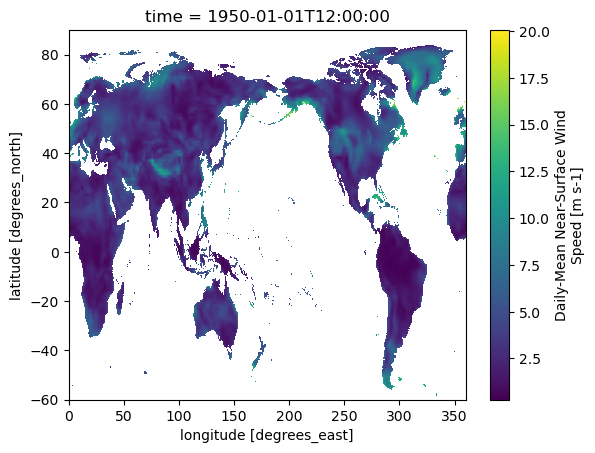

In [34]:
ds.sfcWind.isel(time=0).plot()